In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
import os
import glob
import os.path as osp
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
import torch.nn as nn

In [2]:
path = './all/train_images/'

## Make class for the dataset
Following the tutorial on:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
This class contains the resize and normalize transformations

In [3]:
class PlanktonDS(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, root, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        
        
        self.filenames = []
        self.root = root
        self.transform = transforms.Compose([
    transforms.Resize((35,35)), ## @Delano ik heb dit veranderd want CNN tutorial heeft dit ook is voor nu even makkelijker MAAR DIT IS NIET JUIST WANT DE PLAATJES ZIJN TE KLEIN NU 
    transforms.ToTensor()]) 
        filenames = glob.glob(osp.join(path, '*.jpg'))
        for fn in filenames:
            self.filenames.append(fn)

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = Image.open(self.filenames[index])
        y = self.labels[ID]

        return self.transform(X), y

## Hyperparameters

In [4]:
# Batch size as used in the DataLoader
batch_size = 1

## Loading the labels 

In [5]:
labels_read = pd.read_csv('./all/train_onelabel.csv')
images = labels_read['image'].tolist()
import random
random.shuffle(images)

threshold = int(len(images) *0.7)

partition = {}
partition['train'] = images[:threshold]
partition['validation'] = images[threshold:]


labels = dict(zip(labels_read['image'], labels_read['class'])) 


In [6]:
#Loading the actual data
training_set = PlanktonDS(path, partition['train'], 
                               labels)
training_generator = data.DataLoader(dataset=training_set,
                                           batch_size=batch_size,
                                           shuffle=True)

validation_set = PlanktonDS(path, partition['validation'], 
                               labels)
validation_generator = data.DataLoader(dataset=validation_set,
                                           batch_size=batch_size,
                                           shuffle=True)


In [7]:
num_classes = pd.read_csv('./all/label_map.txt').shape[0]
print('The number of classes is:',num_classes)

The number of classes is: 120


## EDA

tensor([3])


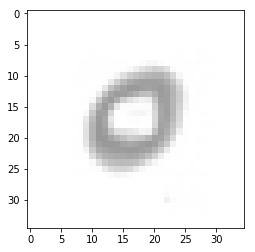

In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(training_generator)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(labels)

In [11]:
print('The length of training set is:' ,len(training_generator))
print('The length of validation set is:' ,len(validation_generator))

The length of training set is: 16942
The length of validation set is: 7262


In [12]:
# How big is an image
for i in range(3):
    image = training_set[i]
    print(image[0].shape)

torch.Size([1, 35, 35])
torch.Size([1, 35, 35])
torch.Size([1, 35, 35])


In [13]:
## Just see one tensor
training_set[35]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]]), 53)

In [14]:
alle_train_classes = []
for i in range(len(training_set)):
    alle_train_classes.append(training_set[i][1])

alle_train_classes_unique = list(set(alle_train_classes))

len(alle_train_classes_unique)

121

## Load label map

In [15]:
label_map = pd.read_table('./all/label_map.txt', delim_whitespace=True, names=('class_name', 'class'))

label_map.head()


,class_name,class
0,unknown_unclassified,0
1,unknown_sticks,1
2,protist_star,2
3,copepod_cyclopoid_oithona,3
4,hydromedusae_solmundella,4


## Structure of DL
Tutorial https://blog.algorithmia.com/convolutional-neural-nets-in-pytorch/
https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864

In [16]:
from torch.autograd import Variable
import torch.nn.functional as F

#class SimpleCNN(torch.nn.Module):
#    def __init__(self):
#        super(SimpleCNN, self).__init__()
#        self.layer1 = nn.Sequential(
#            nn.Conv2d(1, 16, kernel_size=3, padding=1),
#           nn.BatchNorm2d(16),
#            nn.ReLU(),
#            nn.MaxPool2d(2))
#        self.layer2 = nn.Sequential(
#            nn.Conv2d(16, 32, kernel_size=3, padding=1),
#            nn.BatchNorm2d(32),
#            nn.ReLU(),
#            nn.MaxPool2d(2))
#        self.fc = nn.Linear(8*8*32, 121) ## DEZE 121 moet blijven staan
#        
#    def forward(self, x):
#        out = self.layer1(x)
#         print('1', out.shape)
#        out = self.layer2(out)
#         print('2', out.shape)
#        out = out.view(out.size(0), -1)
#         print('3', out.shape)
#        out = self.fc(out)
#         print('4', out.shape)
#        
#        return out

class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.fc = nn.Linear(in_features=17 * 17 * 24, out_features=121)
        
    def forward(self, x):
        
        output = self.conv1(x)
        output = self.relu1(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.pool(output)

        output = self.conv3(output)
        output = self.relu3(output)

        output = self.conv4(output)
        output = self.relu4(output)

        output = output.view(output.size(0), -1)

        output = self.fc(output)

        return output
    

In [17]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    
    #Optimizer
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [18]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = training_generator
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data[0]
            total_train_loss += loss_size.data[0]
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in validation_generator:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data[0]
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(validation_generator)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [19]:
CNN = SimpleCNN()
trainNet(CNN, batch_size=batch_size, n_epochs=5, learning_rate=0.001)

##LET OP ik heb de n_opochs nu op 1 gezet, is t snelst voor nu
## met een learning rate van 0.001 ging de train_loss omhoog. Daarom lager dan dat kiezen.

===== HYPERPARAMETERS =====
batch_size= 1
epochs= 5
learning_rate= 0.001


C:\Users\Delan\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\Delan\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 10% 	 train_loss: 4.38 took: 10.90s
Epoch 1, 20% 	 train_loss: 4.20 took: 10.68s
Epoch 1, 30% 	 train_loss: 4.22 took: 10.69s
Epoch 1, 40% 	 train_loss: 4.19 took: 10.62s
Epoch 1, 50% 	 train_loss: 4.23 took: 10.62s
Epoch 1, 60% 	 train_loss: 4.17 took: 10.74s
Epoch 1, 70% 	 train_loss: 4.20 took: 10.62s
Epoch 1, 80% 	 train_loss: 4.19 took: 10.69s
Epoch 1, 90% 	 train_loss: 4.18 took: 10.62s


C:\Users\Delan\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation loss = 4.17
Epoch 2, 10% 	 train_loss: 4.19 took: 10.78s
Epoch 2, 20% 	 train_loss: 4.14 took: 10.66s
Epoch 2, 30% 	 train_loss: 4.15 took: 10.64s
Epoch 2, 40% 	 train_loss: 4.22 took: 10.57s
Epoch 2, 50% 	 train_loss: 4.18 took: 10.69s
Epoch 2, 60% 	 train_loss: 4.17 took: 10.77s
Epoch 2, 70% 	 train_loss: 4.18 took: 10.72s
Epoch 2, 80% 	 train_loss: 4.15 took: 10.79s
Epoch 2, 90% 	 train_loss: 4.19 took: 10.71s
Validation loss = 4.17
Epoch 3, 10% 	 train_loss: 4.16 took: 10.72s
Epoch 3, 20% 	 train_loss: 4.18 took: 10.67s
Epoch 3, 30% 	 train_loss: 4.19 took: 10.69s
Epoch 3, 40% 	 train_loss: 4.15 took: 10.83s
Epoch 3, 50% 	 train_loss: 4.20 took: 10.73s
Epoch 3, 60% 	 train_loss: 4.16 took: 10.72s
Epoch 3, 70% 	 train_loss: 4.17 took: 10.68s
Epoch 3, 80% 	 train_loss: 4.19 took: 10.78s
Epoch 3, 90% 	 train_loss: 4.19 took: 10.73s
Validation loss = 4.17
Epoch 4, 10% 	 train_loss: 4.18 took: 10.62s
Epoch 4, 20% 	 train_loss: 4.18 took: 10.65s
Epoch 4, 30% 	 train_loss: 4.16

## Use the model and test on the image directory
https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864

In [18]:
labels_read = pd.read_csv('./all/sample.csv')
images = labels_read['image'].tolist()

#random shuffling is not necessary
#import random
#random.shuffle(images)

partition = {}
partition['test'] = images

labels = dict(zip(labels_read['image'], labels_read['class'])) 


In [19]:
path = './all/test_images/'

test_set = PlanktonDS(path, partition['test'], 
                               labels)
test_generator = data.DataLoader(dataset=test_set,
                                           batch_size=batch_size,
                                           shuffle=False)

In [20]:
for i in range(3):
    image = test_set[i]
    print(image[0].shape)

torch.Size([1, 35, 35])
torch.Size([1, 35, 35])
torch.Size([1, 35, 35])


In [21]:
len(test_set)

6132

We are going to predict this images
class of this picture is: 84
class name of this picture is: trichodesmium_puff


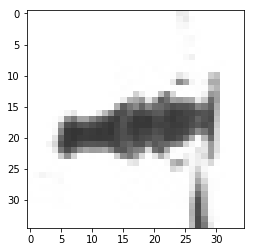

In [22]:
dataiter = iter(test_generator)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('We are going to predict this images')


outputs = CNN(images)
_, predicted = torch.max(outputs, 1)

print('class of this picture is:' ,int(predicted.numpy()))
print('class name of this picture is:' ,label_map.iloc[int(predicted.numpy()),0])



In [77]:
Als bovenstaande cell vaak wordt uitgevoerd, zien we dat deze alleen de output 58 ,105 en 54 heeft globaal.....

Moeten even kijken hoe we alles verbeteren


SyntaxError: invalid syntax (<ipython-input-77-33910561819d>, line 1)

## SUBMITTING

In [29]:
outputdict = {}

with torch.no_grad():
    i = 0
    for data in test_generator:
        image, labels = data
        outputs = CNN(image)
        _, predicted = torch.max(outputs.data, 1)
        outputdict.update({labels_read['image'][i] : predicted})
        i = i + 1

#for k, v in outputdict.items():
    #print(k, v.numpy()[0])

write_dir = './all/results.csv'
csv = open(write_dir, "w")
columnTitleRow = "image,class\n"
csv.write(columnTitleRow)

for key in outputdict.keys():
    picture = key
    className = outputdict[key]
    row = picture + "," + str(className.numpy()[0]) + "\n"
    print(picture + "," + str(className.numpy()[0]))
    csv.write(row)


90715.jpg,84
159631.jpg,84
4294.jpg,84
56548.jpg,84
120979.jpg,84
139460.jpg,84
78510.jpg,84
102841.jpg,84
84208.jpg,84
9591.jpg,84
117254.jpg,84
152598.jpg,84
149049.jpg,84
146084.jpg,84
37310.jpg,84
152812.jpg,84
71417.jpg,84
63562.jpg,84
20690.jpg,84
106297.jpg,84
85794.jpg,84
14572.jpg,84
79727.jpg,84
68132.jpg,84
156128.jpg,84
282.jpg,84
111105.jpg,84
117665.jpg,84
51984.jpg,84
154920.jpg,84
90887.jpg,84
132312.jpg,84
156893.jpg,84
18343.jpg,84
145649.jpg,84
38861.jpg,84
153763.jpg,84
75643.jpg,84
117153.jpg,84
108660.jpg,84
17283.jpg,84
37162.jpg,84
13476.jpg,84
128366.jpg,84
47241.jpg,84
121888.jpg,84
126847.jpg,84
134732.jpg,84
56613.jpg,84
144812.jpg,84
41168.jpg,84
59579.jpg,84
9842.jpg,84
66588.jpg,84
1608.jpg,84
133521.jpg,84
159321.jpg,84
158500.jpg,84
83018.jpg,84
64907.jpg,84
101161.jpg,84
142181.jpg,84
72263.jpg,84
39234.jpg,84
28055.jpg,84
133806.jpg,84
122043.jpg,84
36146.jpg,84
63154.jpg,84
159889.jpg,84
7230.jpg,84
929.jpg,84
142100.jpg,84
13993.jpg,84
98841.jpg,84


135192.jpg,84
98900.jpg,84
131242.jpg,84
134315.jpg,84
76432.jpg,84
83861.jpg,84
146116.jpg,84
150784.jpg,84
148806.jpg,84
80945.jpg,84
135446.jpg,84
84709.jpg,84
45868.jpg,84
140787.jpg,84
87552.jpg,84
97940.jpg,84
101573.jpg,84
108161.jpg,84
50219.jpg,84
30315.jpg,84
134175.jpg,84
153800.jpg,84
38156.jpg,84
98845.jpg,84
64688.jpg,84
80458.jpg,84
42826.jpg,84
4933.jpg,84
58105.jpg,84
132217.jpg,84
13158.jpg,84
38142.jpg,84
44006.jpg,84
154744.jpg,84
67142.jpg,84
122977.jpg,84
102387.jpg,84
22485.jpg,84
133389.jpg,84
132422.jpg,84
120275.jpg,84
116947.jpg,84
110631.jpg,84
15999.jpg,84
39150.jpg,84
97880.jpg,84
95919.jpg,84
29476.jpg,84
139803.jpg,84
27482.jpg,84
134299.jpg,84
69060.jpg,84
34037.jpg,84
158879.jpg,84
74672.jpg,84
120234.jpg,84
30188.jpg,84
40558.jpg,84
28306.jpg,84
58881.jpg,84
126556.jpg,84
131993.jpg,84
113897.jpg,84
29924.jpg,84
26613.jpg,84
159494.jpg,84
4.jpg,84
101811.jpg,84
70989.jpg,84
83910.jpg,84
33809.jpg,84
127808.jpg,84
113071.jpg,84
152582.jpg,84
73725.jpg,

149182.jpg,84
149311.jpg,84
32570.jpg,84
157421.jpg,84
3872.jpg,84
118376.jpg,84
75606.jpg,84
114294.jpg,84
33146.jpg,84
125699.jpg,84
104971.jpg,84
92402.jpg,84
71522.jpg,84
7572.jpg,84
40630.jpg,84
17709.jpg,84
59618.jpg,84
143170.jpg,84
41887.jpg,84
84493.jpg,84
94737.jpg,84
68832.jpg,84
135530.jpg,84
43343.jpg,84
100065.jpg,84
129070.jpg,84
87998.jpg,84
39248.jpg,84
118650.jpg,84
76765.jpg,84
7897.jpg,84
142379.jpg,84
88898.jpg,84
122205.jpg,84
78976.jpg,84
52486.jpg,84
82660.jpg,84
94940.jpg,84
116552.jpg,84
64409.jpg,84
21617.jpg,84
137480.jpg,84
38877.jpg,84
115955.jpg,84
98550.jpg,84
123814.jpg,84
77985.jpg,84
54166.jpg,84
41539.jpg,84
54278.jpg,84
50513.jpg,84
103860.jpg,84
137274.jpg,84
60760.jpg,84
33725.jpg,84
57413.jpg,84
21096.jpg,84
113703.jpg,84
134094.jpg,84
99469.jpg,84
56996.jpg,84
58259.jpg,84
35815.jpg,84
109572.jpg,84
130141.jpg,84
158136.jpg,84
111012.jpg,84
69261.jpg,84
33399.jpg,84
82754.jpg,84
23311.jpg,84
112680.jpg,84
128502.jpg,84
6089.jpg,84
63977.jpg,84
4

34879.jpg,84
50315.jpg,84
46613.jpg,84
65276.jpg,84
126033.jpg,84
42810.jpg,84
55000.jpg,84
127257.jpg,84
69725.jpg,84
17518.jpg,84
34932.jpg,84
30087.jpg,84
2252.jpg,84
74266.jpg,84
49951.jpg,84
85525.jpg,84
147807.jpg,84
75810.jpg,84
66002.jpg,84
7958.jpg,84
1771.jpg,84
13869.jpg,84
76731.jpg,84
24948.jpg,84
76893.jpg,84
67120.jpg,84
11076.jpg,84
13500.jpg,84
68550.jpg,84
8693.jpg,84
124984.jpg,84
117701.jpg,84
45765.jpg,84
22509.jpg,84
52665.jpg,84
5585.jpg,84
109241.jpg,84
84353.jpg,84
75670.jpg,84
110808.jpg,84
131667.jpg,84
33395.jpg,84
49404.jpg,84
75567.jpg,84
126242.jpg,84
100633.jpg,84
82552.jpg,84
85096.jpg,84
154204.jpg,84
35479.jpg,84
748.jpg,84
64443.jpg,84
138042.jpg,84
117672.jpg,84
124421.jpg,84
66266.jpg,84
57842.jpg,84
147950.jpg,84
100985.jpg,84
153169.jpg,84
18745.jpg,84
61907.jpg,84
4280.jpg,84
143198.jpg,84
116631.jpg,84
66398.jpg,84
20403.jpg,84
49510.jpg,84
37873.jpg,84
50131.jpg,84
36350.jpg,84
66368.jpg,84
98720.jpg,84
40308.jpg,84
115633.jpg,84
79442.jpg,84


8504.jpg,84
37725.jpg,84
89259.jpg,84
136743.jpg,84
35441.jpg,84
69661.jpg,84
83726.jpg,84
56396.jpg,84
110408.jpg,84
26979.jpg,84
86992.jpg,84
60680.jpg,84
115105.jpg,84
139012.jpg,84
113154.jpg,84
14448.jpg,84
104825.jpg,84
58338.jpg,84
42216.jpg,84
107900.jpg,84
28652.jpg,84
81771.jpg,84
24923.jpg,84
77276.jpg,84
73679.jpg,84
47378.jpg,84
124828.jpg,84
54480.jpg,84
25120.jpg,84
149145.jpg,84
132458.jpg,84
96594.jpg,84
131879.jpg,84
75185.jpg,84
81321.jpg,84
7954.jpg,84
16461.jpg,84
130057.jpg,84
31119.jpg,84
138057.jpg,84
51948.jpg,84
127646.jpg,84
39023.jpg,84
7590.jpg,84
48537.jpg,84
128037.jpg,84
57476.jpg,84
141644.jpg,84
138836.jpg,84
104499.jpg,84
4800.jpg,84
51823.jpg,84
156594.jpg,84
12770.jpg,84
42276.jpg,84
109647.jpg,84
25579.jpg,84
67777.jpg,84
157762.jpg,84
13062.jpg,84
92256.jpg,84
157619.jpg,84
91488.jpg,84
26647.jpg,84
140105.jpg,84
127912.jpg,84
93691.jpg,84
2596.jpg,84
1327.jpg,84
92287.jpg,84
22768.jpg,84
84834.jpg,84
60123.jpg,84
84296.jpg,84
29827.jpg,84
6881.jp